**IMPORTAR LIBRERIAS**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**CARGAR DATOS**

In [2]:
historico_palma = pd.read_excel("/content/drive/MyDrive/Escenarios/datos/historico-palma.xlsx")
historico_arroz = pd.read_excel("/content/drive/MyDrive/Escenarios/datos/historico-arroz.xlsx")
historico_cacao = pd.read_excel("/content/drive/MyDrive/Escenarios/datos/historico-cacao.xlsx")
historico_porcino = pd.read_excel("/content/drive/MyDrive/Escenarios/datos/historico-porcino.xlsx")
historico_ave = pd.read_excel("/content/drive/MyDrive/Escenarios/datos/historico-ave.xlsx")
proporcion = pd.read_excel("/content/drive/MyDrive/Escenarios/datos/proporcion.xlsx")

**Generar historico a nivel de cuenca desde los datos historicos municipales**

In [3]:
# Calcular hectáreas de cada cultivo en cada cuenca
def calcular_hectareas(historico, cultivo):
    df = historico.melt(id_vars=['Municipio'], var_name='Año', value_name='Hectáreas')
    df['Cultivo'] = cultivo
    df = df.merge(proporcion, left_on='Municipio', right_on='Municipio')
    df['Año'] = df['Año'].astype(int)
    for cuenca in proporcion.columns[1:]:
        df[cuenca] = df['Hectáreas'] * df[cuenca]
    df.drop(['Hectáreas', 'Municipio'], axis=1, inplace=True)
    df = df.melt(id_vars=['Año', 'Cultivo'], var_name='Cuenca', value_name='Hectáreas')
    return df

resultado_palma = calcular_hectareas(historico_palma, 'Palma')
resultado_arroz = calcular_hectareas(historico_arroz, 'Arroz')
resultado_cacao = calcular_hectareas(historico_cacao, 'Cacao')
resultado_porcino = calcular_hectareas(historico_porcino, 'Porcino')
resultado_ave = calcular_hectareas(historico_ave, 'Ave')

# Concatenar datos
resultado_agrupado = pd.concat([resultado_palma, resultado_arroz, resultado_cacao, resultado_porcino,resultado_ave], ignore_index=True)
resultado_agrupado = resultado_agrupado.groupby(['Año', 'Cuenca', 'Cultivo']).sum().reset_index()
# Guardar resultados
resultado_agrupado.to_excel("/content/drive/MyDrive/Escenarios/resultados/historico-cuenca.xlsx", index = False)
resultado_agrupado.head()

Año    Cuenca  Cultivo    Hectáreas
0  2007  Casanare    Arroz  1086.074052
1  2007  Casanare      Ave     0.000000
2  2007  Casanare    Cacao  6993.135725
3  2007  Casanare    Palma     0.000000
4  2007  Casanare  Porcino     0.000000

**Crear los modelos de regresión lineal simple para cada cultivo segun cuenca**

In [4]:
df = pd.read_excel("/content/drive/MyDrive/Escenarios/resultados/historico-cuenca.xlsx")

# Initialize an empty DataFrame to store the results
result_df = pd.DataFrame(columns=['Cuenca', 'Cultivo', 'Ecuación de la Recta', 'R^2'])

# Group the data by 'Cuenca' and 'Cultivo'
grouped = df.groupby(['Cuenca', 'Cultivo'])

# Loop through each group to fit a simple linear regression model
for (cuenca, cultivo), group_data in grouped:
    X = group_data['Año'].values.reshape(-1, 1)
    y = group_data['Hectáreas'].values

    # Fit the model
    model = LinearRegression()
    model.fit(X, y)

    # Get the slope and intercept of the line
    slope = model.coef_[0]
    intercept = model.intercept_

    # Get the R^2 value
    r_squared = model.score(X, y)

    # Create the equation of the line
    equation = f'y = {slope:.4f} * x + {intercept:.4f}'

    # Append the results to the DataFrame
    result_df = result_df.append({
        'Cuenca': cuenca,
        'Cultivo': cultivo,
        'Ecuación de la Recta': equation,
        'R^2': r_squared
    }, ignore_index=True)

result_df.to_excel("/content/drive/MyDrive/Escenarios/resultados/modelos-regresion-cultivo.xlsx", index = False)
result_df.head()

Cuenca  Cultivo                 Ecuación de la Recta       R^2
0  Casanare    Arroz    y = 1482.7601 * x + -2974065.7714  0.891787
1  Casanare      Ave  y = 15866.6383 * x + -31896609.4036  0.807204
2  Casanare    Cacao      y = 354.5253 * x + -704296.6807  0.913401
3  Casanare    Palma          y = -0.8147 * x + 1681.4223  0.004108
4  Casanare  Porcino    y = 3394.0233 * x + -6819731.9107  0.700900

**Generación de predicción 2040**

In [5]:
# Ajuste de Modelos de Regresión Lineal
resultados_predicciones = pd.DataFrame(columns=['Cuenca', 'Cultivo', 'Año', 'Predicción', 'IC_inf', 'IC_sup', 'IP_inf', 'IP_sup'])
cuencas_unicas = resultado_agrupado['Cuenca'].unique()
cultivos_unicos = resultado_agrupado['Cultivo'].unique()
for cuenca in cuencas_unicas:
    for cultivo in cultivos_unicos:
        datos_cuenca_cultivo = resultado_agrupado[(resultado_agrupado['Cuenca'] == cuenca) & (resultado_agrupado['Cultivo'] == cultivo)]
        modelo = ols('Hectáreas ~ Año', data=datos_cuenca_cultivo).fit()

        # Para la línea de tendencia, IC e IP desde el 2007 hasta el 2040
        predicciones_df = pd.DataFrame({'Año': np.arange(2007, 2041)})
        predicciones_df['Cuenca'] = cuenca
        predicciones_df['Cultivo'] = cultivo
        predicciones = modelo.get_prediction(predicciones_df[['Año']])
        predicciones_summary = predicciones.summary_frame(alpha=0.05) # Intervalos al 95%
        predicciones_df['Predicción'] = predicciones_summary['mean']
        predicciones_df['IC_inf'] = predicciones_summary['mean_ci_lower']
        predicciones_df['IC_sup'] = predicciones_summary['mean_ci_upper']
        predicciones_df['IP_inf'] = predicciones_summary['obs_ci_lower']
        predicciones_df['IP_sup'] = predicciones_summary['obs_ci_upper']

        # Solo aplicar la predicción aleatoria en el rango de 2023 a 2040
        predicciones_df['Predicción_aleatoria'] = predicciones_df.apply(lambda row: np.random.uniform(row['IP_inf'], row['IP_sup']) if row['Año'] >= 2023 else np.nan, axis=1)

        resultados_predicciones = resultados_predicciones.append(predicciones_df, ignore_index=True)

# Corregir el tipo de datos
resultados_predicciones['Año'] = resultados_predicciones['Año'].astype(int)

# Generar predicciones aleatorias dentro de los intervalos de predicción
np.random.seed(42)
resultados_predicciones['Predicción_aleatoria'] = resultados_predicciones.apply(lambda row: np.random.uniform(row['IP_inf'], row['IP_sup']), axis=1)
resultados_predicciones.to_excel("/content/drive/MyDrive/Escenarios/resultados/prediccion-2007-2040.xlsx", index = False)
resultados_predicciones.head()

Cuenca Cultivo   Año   Predicción       IC_inf       IC_sup       IP_inf  \
0  Casanare   Arroz  2007  1833.793538  -772.666242  4440.253318 -4215.830928   
1  Casanare   Arroz  2008  3316.553660   957.232629  5675.874692 -2630.775095   
2  Casanare   Arroz  2009  4799.313782  2674.583581  6924.043983 -1058.911377   
3  Casanare   Arroz  2010  6282.073904  4374.750997  8189.396812   499.150399   
4  Casanare   Arroz  2011  7764.834026  6051.182232  9478.485821  2042.865303   

         IP_sup  Predicción_aleatoria  
0   7883.418004            315.823205  
1   9263.882416           8677.645970  
2  10657.538942           7517.459276  
3  12064.997410           7423.142839  
4  13486.802749           3828.332865

**Visualización de los modelos de regresión lineal simple**

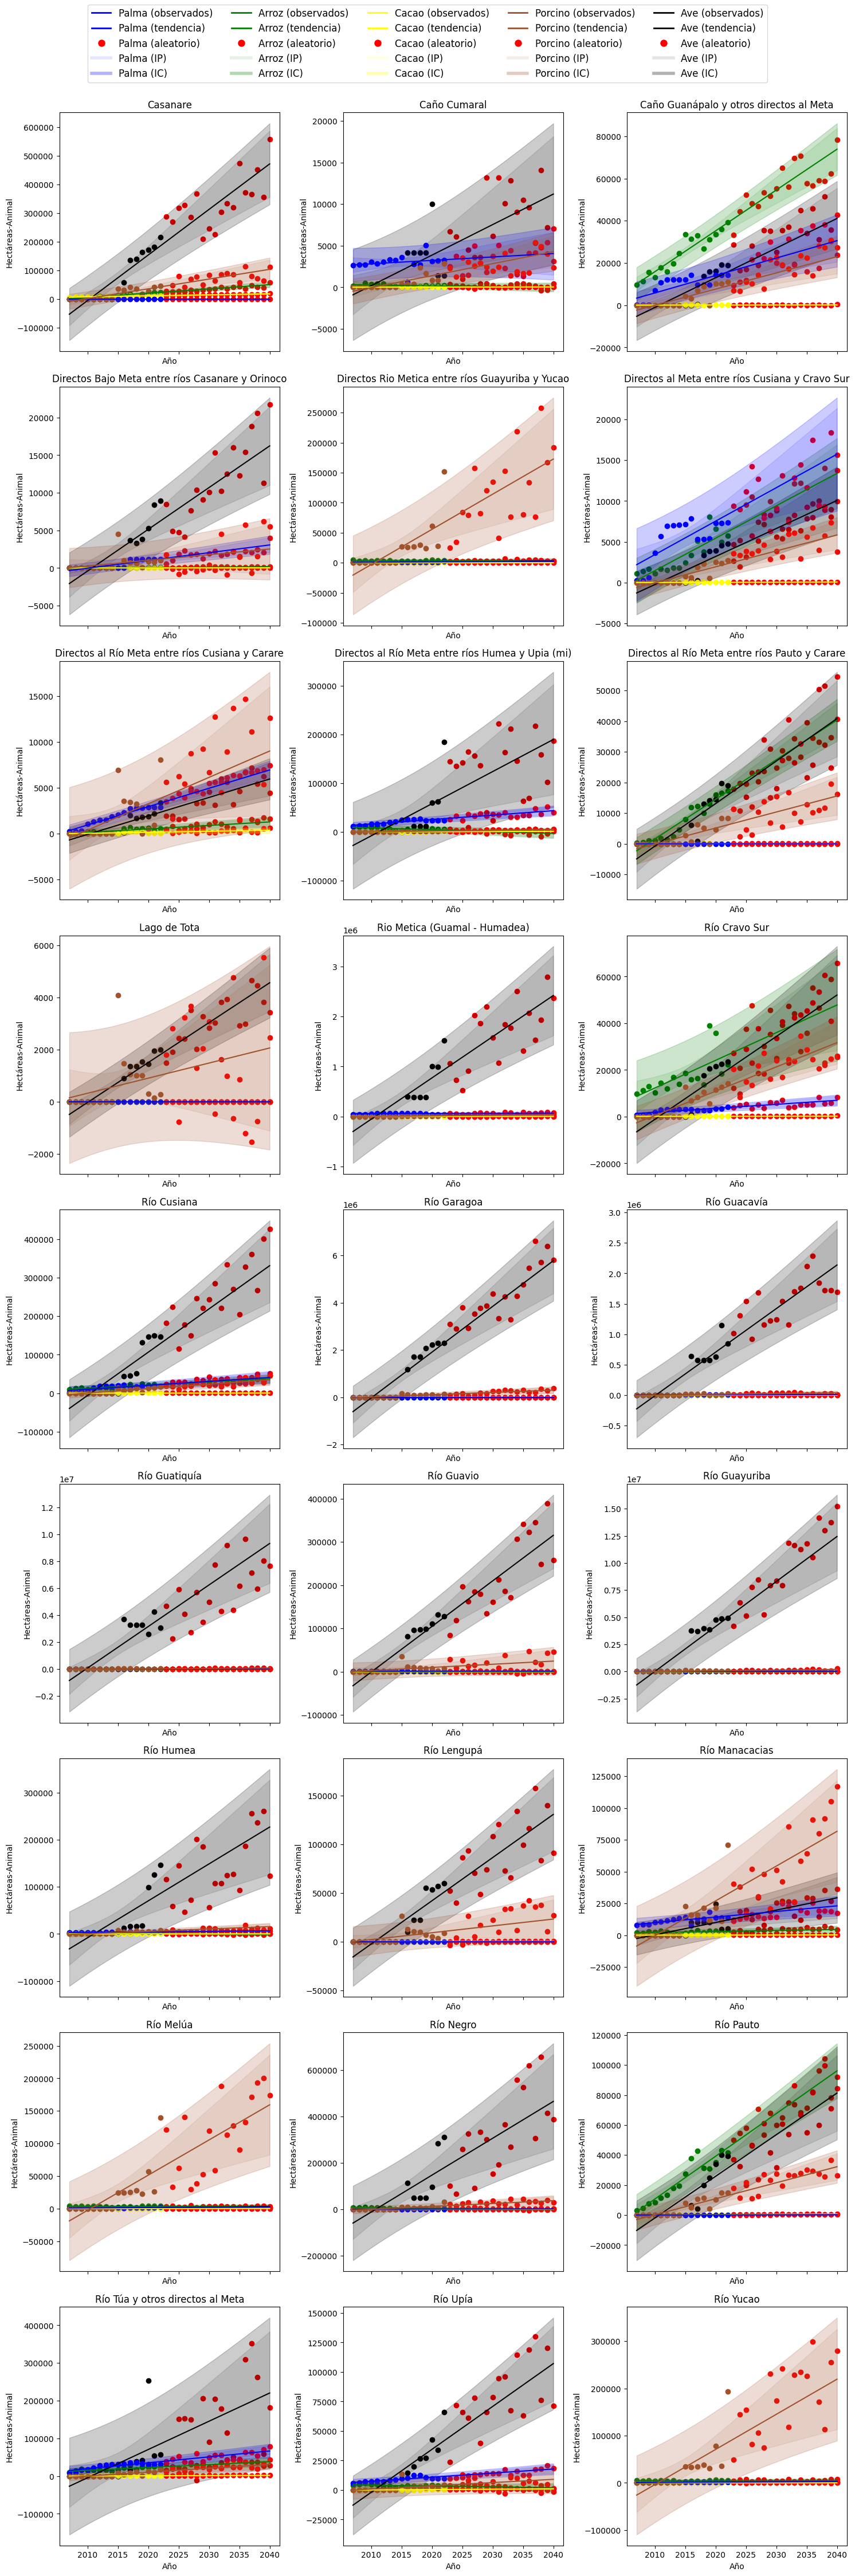

In [6]:
# Visualizar resultados
colores = {'Palma': 'blue', 'Arroz': 'green', 'Cacao': 'yellow','Porcino': 'sienna', 'Ave': 'black'} # se elimino bovino
fig, axes = plt.subplots(nrows=9, ncols=3, figsize=(15, 45), sharex=True)
lineas = []
etiquetas = []
for cultivo, color in colores.items():
    lineas.extend([plt.Line2D([0], [0], color=color, lw=2),
                   plt.Line2D([0], [0], color=color, lw=2, linestyle='-'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10),
                   plt.Line2D([0], [0], color=color, lw=4, alpha=0.1),
                   plt.Line2D([0], [0], color=color, lw=4, alpha=0.3)])
    etiquetas.extend([f'{cultivo} (observados)',
                      f'{cultivo} (tendencia)',
                      f'{cultivo} (aleatorio)',
                      f'{cultivo} (IP)',
                      f'{cultivo} (IC)'])

for i, cuenca in enumerate(cuencas_unicas):
    ax = axes[i // 3, i % 3]
    datos_cuenca = resultados_predicciones[resultados_predicciones['Cuenca'] == cuenca]
    for cultivo in cultivos_unicos:
        datos_cultivo = datos_cuenca[datos_cuenca['Cultivo'] == cultivo]
        datos_historicos = resultado_agrupado[(resultado_agrupado['Cuenca'] == cuenca) & (resultado_agrupado['Cultivo'] == cultivo)]

        # Visualizar solo los datos aleatorios predichos desde el 2023 hasta el 2040
        datos_cultivo_futuro = datos_cultivo[datos_cultivo['Año'] >= 2023]

        ax.scatter(datos_historicos['Año'], datos_historicos['Hectáreas'], color=colores[cultivo])
        ax.plot(datos_cultivo['Año'], datos_cultivo['Predicción'], color=colores[cultivo], linestyle='-')
        ax.scatter(datos_cultivo_futuro['Año'], datos_cultivo_futuro['Predicción_aleatoria'], color='red')
        ax.fill_between(datos_cultivo['Año'], datos_cultivo['IP_inf'], datos_cultivo['IP_sup'], color=colores[cultivo], alpha=0.2) # Intervalo de Predicción
        ax.fill_between(datos_cultivo['Año'], datos_cultivo['IC_inf'], datos_cultivo['IC_sup'], color=colores[cultivo], alpha=0.1) # Intervalo de Confianza

    ax.set_title(cuenca)
    ax.set_xlabel('Año')
    ax.set_ylabel('Hectáreas-Animal')

fig.legend(lineas, etiquetas, loc='upper center', ncol=5, fontsize='large')
plt.tight_layout(rect=[0, 0, 1, 0.965])
plt.show()

**Excel con los resultados de predicción tendencial 2023 - 2040**

**Resultados compilados**

In [7]:
prediccion_2023_2040 = resultados_predicciones.query('2023 <= Año <= 2040')
prediccion_2023_2040.rename(columns={'Predicción': 'Hectareas'}, inplace=True)
prediccion_2023_2040 = prediccion_2023_2040[['Cuenca', 'Cultivo', 'Año', 'Hectareas', 'IC_inf', 'IC_sup']]
prediccion_2023_2040[['Hectareas', 'IC_inf', 'IC_sup']] = prediccion_2023_2040[['Hectareas', 'IC_inf', 'IC_sup']].round().astype(int)
prediccion_2023_2040.to_excel("/content/drive/MyDrive/Escenarios/resultados/prediccion-2023-2040.xlsx", index = False)
prediccion_2023_2040.head()

Cuenca Cultivo   Año  Hectareas  IC_inf  IC_sup
16  Casanare   Arroz  2023      25558   22695   28421
17  Casanare   Arroz  2024      27041   23914   30167
18  Casanare   Arroz  2025      28523   25128   31919
19  Casanare   Arroz  2026      30006   26338   33674
20  Casanare   Arroz  2027      31489   27544   35434

# **Cultivos Agricolas**

**Filtrar los valores de cacao, arroz, palma**

In [8]:
prediccion_2023_2040_agricola= prediccion_2023_2040.query("Cultivo == 'Arroz' or Cultivo == 'Palma'or Cultivo == 'Cacao'")
prediccion_2023_2040_agricola.to_excel("/content/drive/MyDrive/Escenarios/resultados/prediccion-2023-2040-agricola.xlsx", index = False)
prediccion_2023_2040_agricola.head()

Cuenca Cultivo   Año  Hectareas  IC_inf  IC_sup
16  Casanare   Arroz  2023      25558   22695   28421
17  Casanare   Arroz  2024      27041   23914   30167
18  Casanare   Arroz  2025      28523   25128   31919
19  Casanare   Arroz  2026      30006   26338   33674
20  Casanare   Arroz  2027      31489   27544   35434

**Visualizar producción agrícola**

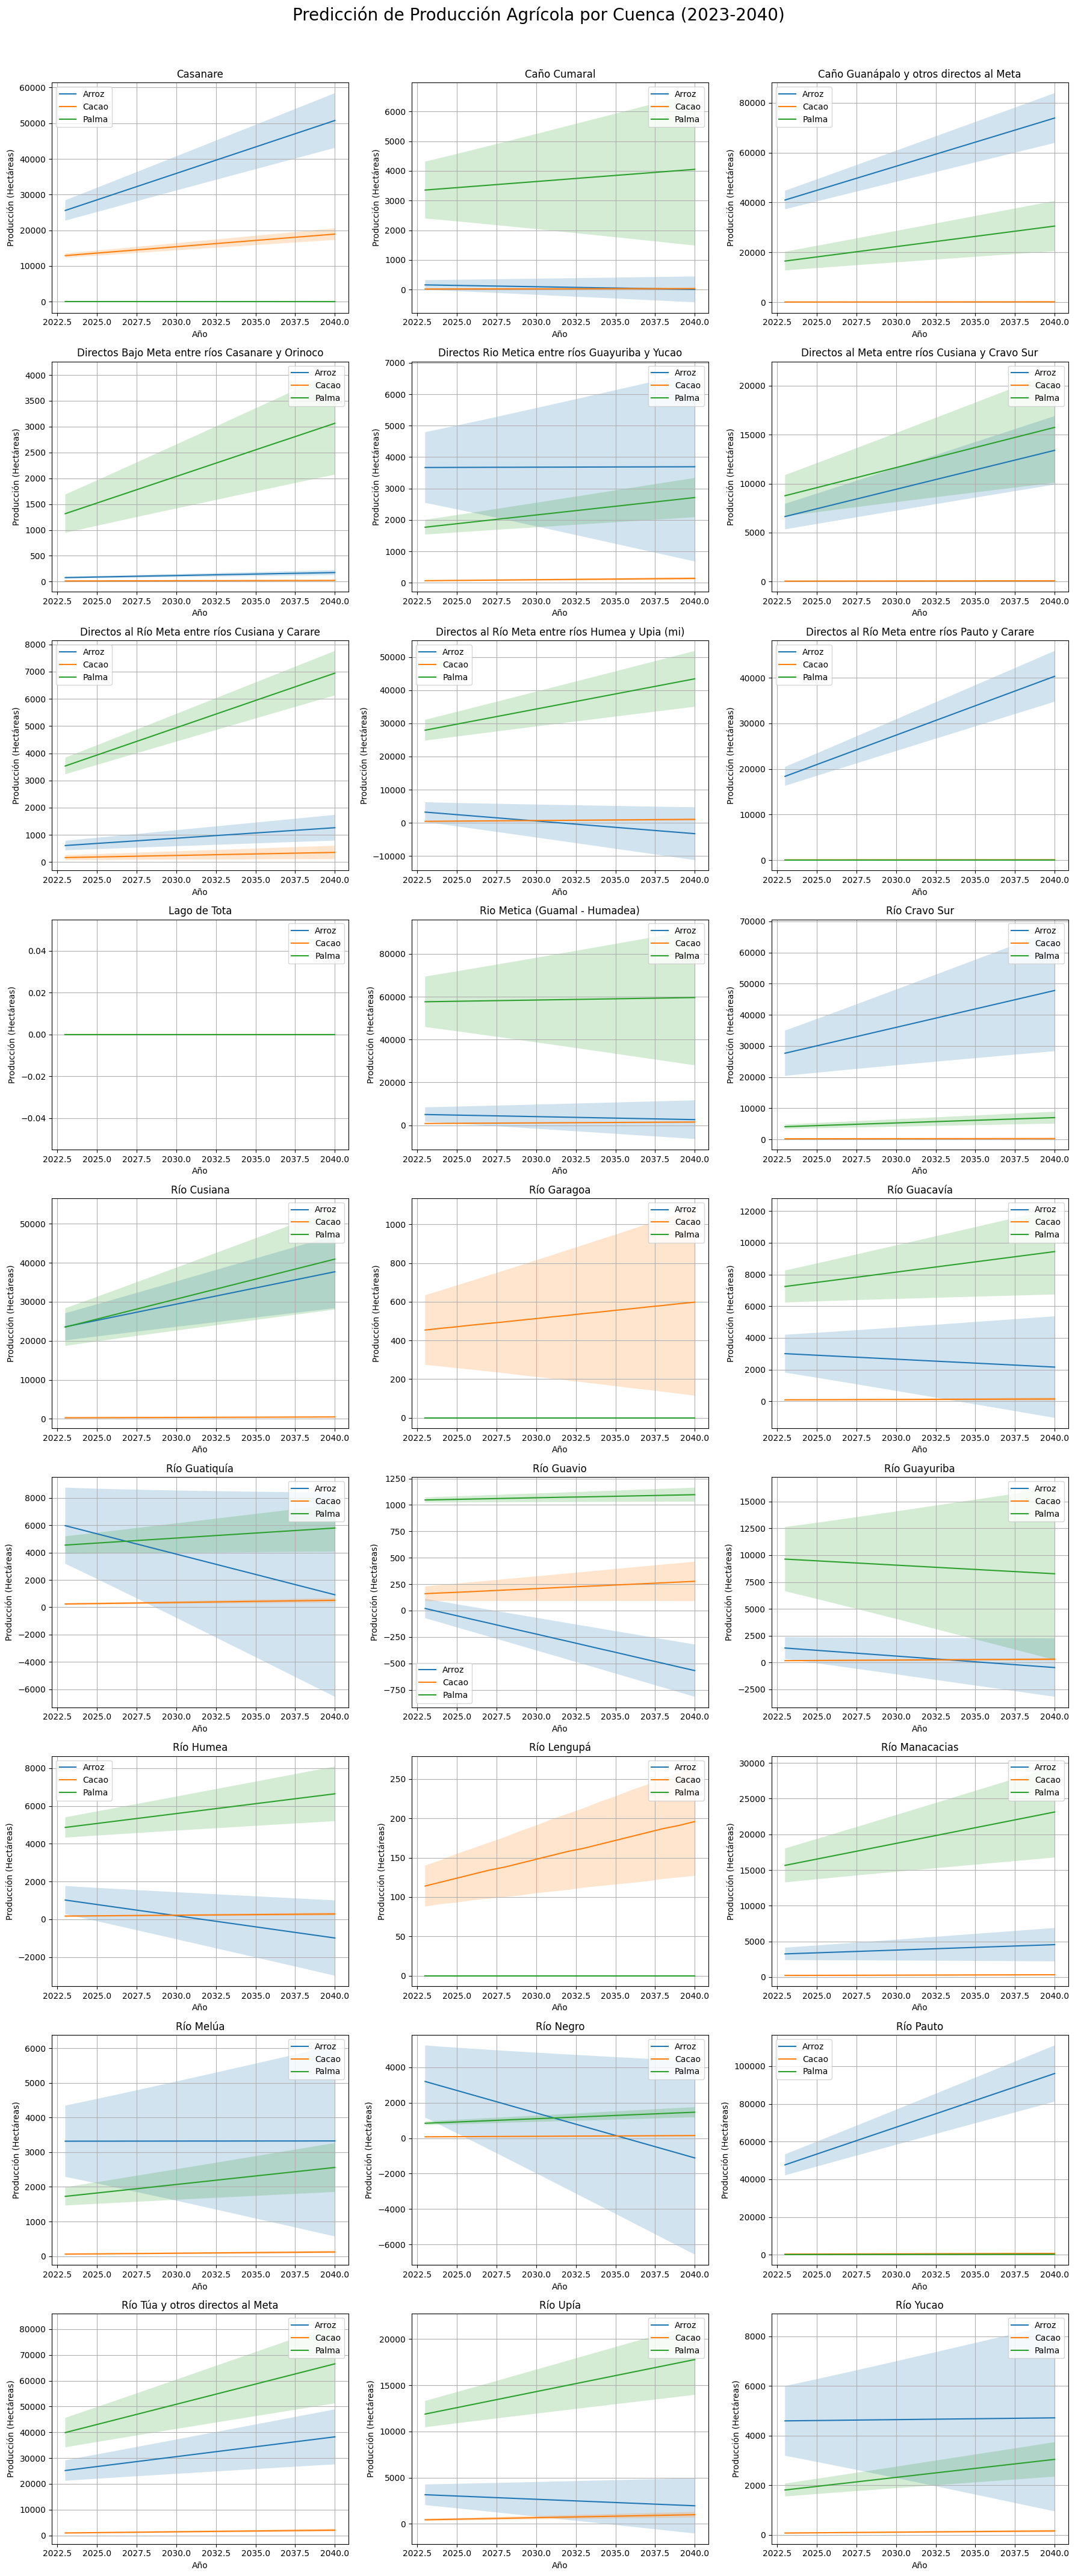

In [9]:
df = prediccion_2023_2040_agricola

# Obtener la lista de cuencas y cultivos únicos
unique_cuencas = df['Cuenca'].unique()
unique_cultivos = df['Cultivo'].unique()

# Configurar el subplot
fig, axes = plt.subplots(9, 3, figsize=(18, 45))
fig.suptitle('Predicción de Producción Agrícola por Cuenca (2023-2040)', fontsize=20)

# Aplanar el array de ejes para iterar más fácilmente
axes_flat = axes.flatten()

# Iterar a través de cada cuenca y plotear los datos
for idx, cuenca in enumerate(unique_cuencas):
    ax = axes_flat[idx]
    cuenca_data = df[df['Cuenca'] == cuenca]

    for cultivo in unique_cultivos:
        cultivo_data = cuenca_data[cuenca_data['Cultivo'] == cultivo]
        if not cultivo_data.empty:
            ax.plot(cultivo_data['Año'], cultivo_data['Hectareas'], label=f"{cultivo}")
            ax.fill_between(cultivo_data['Año'], cultivo_data['IC_inf'], cultivo_data['IC_sup'], alpha=0.2)

    ax.set_title(cuenca)
    ax.set_xlabel('Año')
    ax.set_ylabel('Producción (Hectáreas)')
    ax.legend()
    ax.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

# **Producción Pecuaria**

**Filtramos los datos de predicción del Porcino y Ave 2023-2040**

In [10]:
prediccion_2023_2040_pecuaria = prediccion_2023_2040.query("Cultivo == 'Porcino'or Cultivo == 'Ave'") # se elimino bovino
prediccion_2023_2040_pecuaria = prediccion_2023_2040_pecuaria.rename(columns={'Hectareas': 'Animales'})
prediccion_2023_2040_pecuaria.to_excel("/content/drive/MyDrive/Escenarios/resultados/prediccion-2023-2040-pecuario.xlsx", index = False)
prediccion_2023_2040_pecuaria.head()

Cuenca Cultivo   Año  Animales  IC_inf  IC_sup
50  Casanare     Ave  2023    201600  158620  244580
51  Casanare     Ave  2024    217466  170531  264402
52  Casanare     Ave  2025    233333  182362  284304
53  Casanare     Ave  2026    249200  194129  304270
54  Casanare     Ave  2027    265066  205847  324285

**Generacion proyección Bovino y unir con la proyección anterior**

In [11]:
historico_bovino_animal_df = pd.read_excel("/content/drive/MyDrive/Escenarios/datos/historico-bovino-animal.xlsx")
prediccion_2023_2040_df = pd.read_excel("/content/drive/MyDrive/Escenarios/resultados/prediccion-2023-2040-pecuario.xlsx")
proporcion_df  = pd.read_excel("/content/drive/MyDrive/Escenarios/datos/proporcion.xlsx")

In [12]:
# Melt the historical data to long format for easier calculations
historico_bovino_animal_long = historico_bovino_animal_df.melt(id_vars=["Municipio"], var_name="Año", value_name="Poblacion")

# Merge with the proportion data to get the basin level proportion for each municipality and year
historico_basin = pd.merge(historico_bovino_animal_long, proporcion_df, on="Municipio", how="left")

# Calculate the historical data at the basin level
basin_columns = proporcion_df.columns[1:]
for basin in basin_columns:
    historico_basin[basin] = historico_basin["Poblacion"] * historico_basin[basin]

# Group by year and sum up to get the total population for each basin
historico_basin_grouped = historico_basin.groupby("Año")[basin_columns].sum().reset_index()

historico_basin_grouped.head()

Año  Caño Cumaral  Caño Guanápalo y otros directos al Meta       Casanare  \
0  2007           0.0                            202100.433911  309111.642758   
1  2008           0.0                            204143.650259  308394.152490   
2  2009           0.0                            214987.118573  311718.589581   
3  2010           0.0                            231282.864759  329045.731527   
4  2011           0.0                            235241.034598  335820.610532   

   Directos al Meta entre ríos Cusiana y Cravo Sur  \
0                                     45782.508699   
1                                     45125.773577   
2                                     47442.767473   
3                                     50699.385552   
4                                     51292.202637   

   Directos al Río Meta entre ríos Cusiana y Carare  \
0                                       1091.174935   
1                                       1089.112819   
2                                       1154.326986   
3                                       1218.722706   
4                                       1240.920599   

   Directos al Río Meta entre ríos Humea y Upia (mi)  \
0                                           0.972400   
1                                           1.055748   
2                                           1.139097   
3                                           1.055748   
4                                           1.111314   

   Directos al Río Meta entre ríos Pauto y Carare  \
0                                   154182.856357   
1                                   154185.059000   
2                                   156828.231440   
3                                   160352.461360   
4                                   160352.461360   

   Directos Bajo Meta entre ríos Casanare y Orinoco  \
0                                        327.864630   
1                                        327.869314   
2                                        333.489931   
3                                        340.984087   
4                                        340.984087   

   Directos Rio Metica entre ríos Guayuriba y Yucao  ...  Río Humea  \
0                                        436.817395  ...        0.0   
1                                        444.485662  ...        0.0   
2                                        451.227561  ...        0.0   
3                                        434.435380  ...        0.0   
4                                        468.609657  ...        0.0   

   Río Lengupá  Río Manacacias  Río Melúa  Rio Metica (Guamal - Humadea)  \
0     1.836812      138.676550        0.0                            0.0   
1     1.836812      146.442437        0.0                            0.0   
2     1.763340      147.551849        0.0                            0.0   
3     1.689867      149.659733        0.0                            0.0   
4     1.689867      149.659733        0.0                            0.0   

   Río Negro      Río Pauto  Río Túa y otros directos al Meta      Río Upía  \
0        0.0  277036.410060                     221851.076378  32932.561549   
1        0.0  278699.644642                     220917.658565  33919.063935   
2        0.0  290581.124712                     220549.950633  33966.186440   
3        0.0  300772.020459                     210155.431348  32167.898621   
4        0.0  316428.702193                     222276.728273  32935.130183   

   Río Yucao  
0   4.369510  
1   4.614203  
2   4.649159  
3   4.715576  
4   4.715576  

[5 rows x 28 columns]

In [13]:
# Filter the data for the year 2022
historico_basin_2022 = historico_basin_grouped[historico_basin_grouped["Año"] == 2022.0]

# Drop the 'Año' column as it's no longer needed for this subset
historico_basin_2022 = historico_basin_2022.drop(columns=["Año"])

# Initialize an empty dataframe to store the predictions
predictions_df = pd.DataFrame()

# Calculate the predictions and confidence intervals for each basin
growth_rate = 0.015  # Annual growth rate of 1.5%
confidence_factor = 0.1  # +/- 10% for confidence interval
years_to_predict = np.arange(2023, 2041)  # Years from 2023 to 2040

for basin in basin_columns:
    initial_population = historico_basin_2022[basin].values[0]
    future_population = initial_population * ((1 + growth_rate) ** (years_to_predict - 2022))
    ci_lower = future_population * (1 - confidence_factor)
    ci_upper = future_population * (1 + confidence_factor)

    temp_df = pd.DataFrame({
        "Cuenca": basin,
        "Año": years_to_predict,
        "Animales": future_population.round().astype(int),
        "IC_inf": ci_lower.round().astype(int),
        "IC_sup": ci_upper.round().astype(int),
        "Cultivo": "Bovino"  # Assuming the animal is bovine
    })

    predictions_df = pd.concat([predictions_df, temp_df], ignore_index=True)

predictions_df.head()

Cuenca   Año  Animales  IC_inf  IC_sup Cultivo
0  Caño Cumaral  2023     35244   31720   38768  Bovino
1  Caño Cumaral  2024     35773   32195   39350  Bovino
2  Caño Cumaral  2025     36309   32678   39940  Bovino
3  Caño Cumaral  2026     36854   33168   40539  Bovino
4  Caño Cumaral  2027     37407   33666   41147  Bovino

**Concatenar las 3 producciones**

In [14]:
# Append the new predictions to the existing prediction dataframe
final_prediction_df = pd.concat([prediccion_2023_2040_df, predictions_df], ignore_index=True)
final_prediction_df = final_prediction_df.sort_values(by=['Cuenca', 'Cultivo', 'Año'])
final_prediction_df = final_prediction_df.rename(columns={'Cultivo': 'Produccion'})
final_prediction_df.to_excel("/content/drive/MyDrive/Escenarios/resultados/prediccion-2023-2040-pecuario.xlsx", index = False)
final_prediction_df

Cuenca Produccion   Año  Animales  IC_inf  IC_sup
0     Casanare        Ave  2023    201600  158620  244580
1     Casanare        Ave  2024    217466  170531  264402
2     Casanare        Ave  2025    233333  182362  284304
3     Casanare        Ave  2026    249200  194129  304270
4     Casanare        Ave  2027    265066  205847  324285
..         ...        ...   ...       ...     ...     ...
967  Río Yucao    Porcino  2036    189753   99677  279829
968  Río Yucao    Porcino  2037    197190  103105  291275
969  Río Yucao    Porcino  2038    204626  106525  302728
970  Río Yucao    Porcino  2039    212063  109939  314188
971  Río Yucao    Porcino  2040    219500  113347  325653

[1458 rows x 6 columns]

**Visualizar la producción pecuaria**

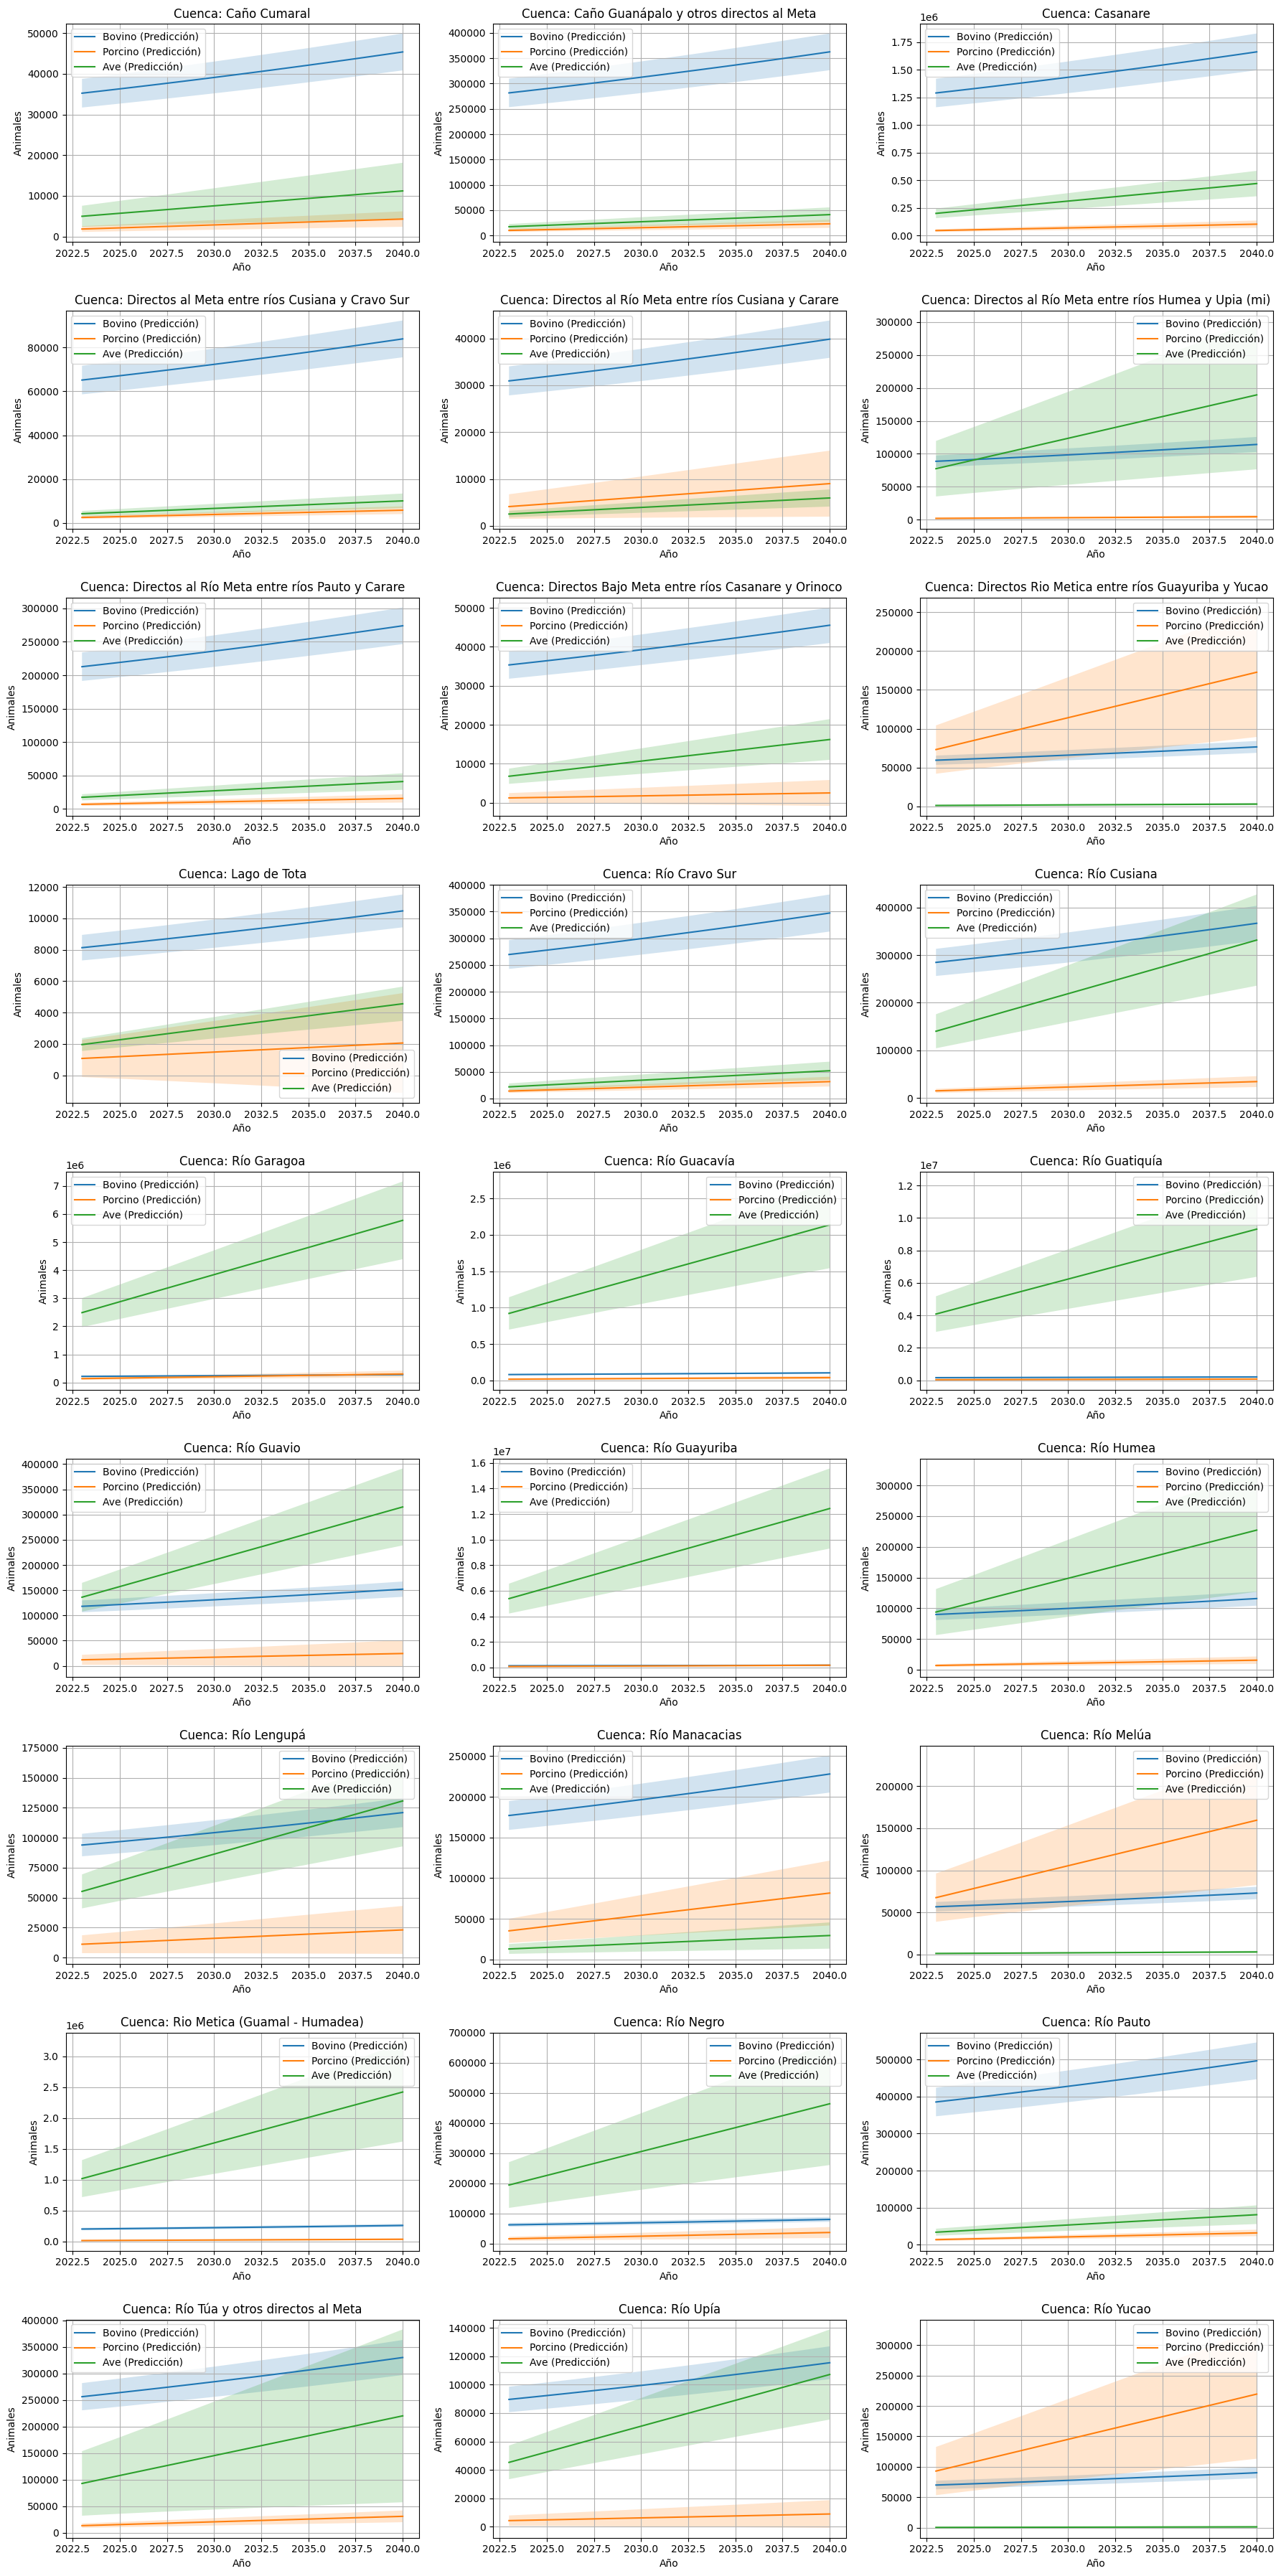

In [15]:
# Filter out only the Bovino, Porcino, and Aves from the final prediction dataframe
filtered_df = final_prediction_df[final_prediction_df['Produccion'].isin(['Bovino', 'Porcino', 'Ave'])]

# Create subplots
fig, axs = plt.subplots(9, 3, figsize=(18, 36))
fig.subplots_adjust(hspace=0.5, wspace=0.3)

# Flatten the axis array for easier indexing
axs = axs.flatten()

# Loop through each unique basin
for i, basin in enumerate(basin_columns):
    ax = axs[i]
    basin_df = filtered_df[filtered_df['Cuenca'] == basin]

    # Plot each type of animal for this basin
    for animal in ['Bovino', 'Porcino', 'Ave']:
        animal_df = basin_df[basin_df['Produccion'] == animal]
        if not animal_df.empty:
            ax.plot(animal_df['Año'], animal_df['Animales'], label=f"{animal} (Predicción)")
            ax.fill_between(animal_df['Año'], animal_df['IC_inf'], animal_df['IC_sup'], alpha=0.2)

    ax.set_title(f"Cuenca: {basin}")
    ax.set_xlabel("Año")
    ax.set_ylabel("Animales")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


# **POBLACION**

**Agregar la proyección del DANE de población 2020-2035 a nivel de cuenca**

In [16]:
proporcion_urbano = pd.read_excel("/content/drive/MyDrive/Escenarios/datos/proporcion-urbano.xlsx")
proporcion_rural = pd.read_excel("/content/drive/MyDrive/Escenarios/datos/proporcion.xlsx")
proyeccion_urbano = pd.read_excel("/content/drive/MyDrive/Escenarios/datos/proyeccion-dane-urbano.xlsx")
proyeccion_rural = pd.read_excel("/content/drive/MyDrive/Escenarios/datos/proyeccion-dane-rural.xlsx")

In [18]:
# Definimos una función para calcular la población por cuenca basado en las proporciones y la proyección poblacional de cada municipio.
def calcular_poblacion_por_cuenca(proporcion, proyeccion):
    # Unimos los DataFrames según la columna "Municipio"
    df_merged = pd.merge(proyeccion, proporcion, on="Municipio", how="right")

    # Llenamos los valores NaN con ceros
    df_merged.fillna(0, inplace=True)

    # Obtenemos las columnas que corresponden a los años y las cuencas
    columnas_anios = [col for col in df_merged.columns if isinstance(col, (int, float))]
    columnas_cuencas = [col for col in df_merged.columns if col not in columnas_anios + ["Municipio"]]

    # Calculamos la población por cuenca para cada año
    df_resultado = pd.DataFrame()
    for cuenca in columnas_cuencas:
        for anio in columnas_anios:
            poblacion_cuenca_anio = round((df_merged[anio] * df_merged[cuenca]).sum())
            df_resultado = df_resultado.append({"Cuenca": cuenca, "Año": anio, "Población": poblacion_cuenca_anio}, ignore_index=True)

    return df_resultado

# Calculamos la población por cuenca para las áreas urbana y rural
poblacion_cuenca_urbana = calcular_poblacion_por_cuenca(proporcion_urbano, proyeccion_urbano)
poblacion_cuenca_urbana["Area"] = "Urbana"

poblacion_cuenca_rural = calcular_poblacion_por_cuenca(proporcion_rural, proyeccion_rural)
poblacion_cuenca_rural["Area"] = "Rural"

# Mostramos los primeros registros de cada resultado
poblacion_cuenca_urbana.head(), poblacion_cuenca_rural.head()

# Concatenamos los resultados de población urbana y rural en un solo DataFrame
poblacion_cuenca_total = pd.concat([poblacion_cuenca_urbana, poblacion_cuenca_rural], ignore_index=True)

# Reorganizamos las columnas para que estén en el orden solicitado
poblacion_cuenca_total = poblacion_cuenca_total[["Cuenca", "Area", "Año", "Población"]]

# Mostramos los primeros registros del DataFrame concatenado
poblacion_cuenca_total.head()

Cuenca    Area   Año  Población
0  Caño Cumaral  Urbana  2020          0
1  Caño Cumaral  Urbana  2021          0
2  Caño Cumaral  Urbana  2022          0
3  Caño Cumaral  Urbana  2023          0
4  Caño Cumaral  Urbana  2024          0

**Extender mediante una regresión lineal simple los años 2036-2040**

In [19]:
# Definimos una función para ajustar y predecir la población utilizando regresión lineal
def predecir_poblacion(df, anios_futuros):
    predicciones = []

    # Separamos el DataFrame por cuenca y área (urbana/rural)
    for cuenca in df["Cuenca"].unique():
        for area in df["Area"].unique():
            # Filtramos los datos correspondientes a la cuenca y el área
            df_filtrado = df[(df["Cuenca"] == cuenca) & (df["Area"] == area)]

            # Preparamos los datos para el modelo
            X = df_filtrado["Año"].values.reshape(-1, 1)
            y = df_filtrado["Población"].values

            # Creamos y entrenamos el modelo de regresión lineal
            modelo = LinearRegression()
            modelo.fit(X, y)

            # Realizamos las predicciones para los años futuros
            for anio in anios_futuros:
                poblacion_predicha = round(modelo.predict(np.array([[anio]]))[0])
                predicciones.append({"Cuenca": cuenca, "Area": area, "Año": anio, "Población": poblacion_predicha})

    return pd.DataFrame(predicciones)

# Definimos los años futuros para los que queremos realizar predicciones
anios_futuros = np.arange(2036, 2041)

# Realizamos las predicciones
predicciones = predecir_poblacion(poblacion_cuenca_total, anios_futuros)

# Mostramos las primeras predicciones
predicciones.head()

Cuenca    Area   Año  Población
0  Caño Cumaral  Urbana  2036          0
1  Caño Cumaral  Urbana  2037          0
2  Caño Cumaral  Urbana  2038          0
3  Caño Cumaral  Urbana  2039          0
4  Caño Cumaral  Urbana  2040          0

In [20]:
# Concatenamos las predicciones al DataFrame original
poblacion_cuenca_total_extendido = pd.concat([poblacion_cuenca_total, predicciones], ignore_index=True)

# Filtramos el DataFrame para incluir solo los años desde 2023 hasta 2040
poblacion_cuenca_filtrado = poblacion_cuenca_total_extendido[(poblacion_cuenca_total_extendido["Año"] >= 2023) &
                                                            (poblacion_cuenca_total_extendido["Año"] <= 2040)]

# Mostramos los primeros registros del DataFrame filtrado
poblacion_cuenca_filtrado = poblacion_cuenca_filtrado.sort_values(by=['Cuenca', 'Area', 'Año'])
poblacion_cuenca_filtrado.to_excel("/content/drive/MyDrive/Escenarios/resultados/prediccion-2023-2040-poblacion.xlsx", index = False)
poblacion_cuenca_filtrado

Cuenca    Area   Año  Población
467    Casanare   Rural  2023      83272
468    Casanare   Rural  2024      84549
469    Casanare   Rural  2025      85622
470    Casanare   Rural  2026      86505
471    Casanare   Rural  2027      87319
...         ...     ...   ...        ...
1124  Río Yucao  Urbana  2036          0
1125  Río Yucao  Urbana  2037          0
1126  Río Yucao  Urbana  2038          0
1127  Río Yucao  Urbana  2039          0
1128  Río Yucao  Urbana  2040          0

[972 rows x 4 columns]

**Visualizar la población**

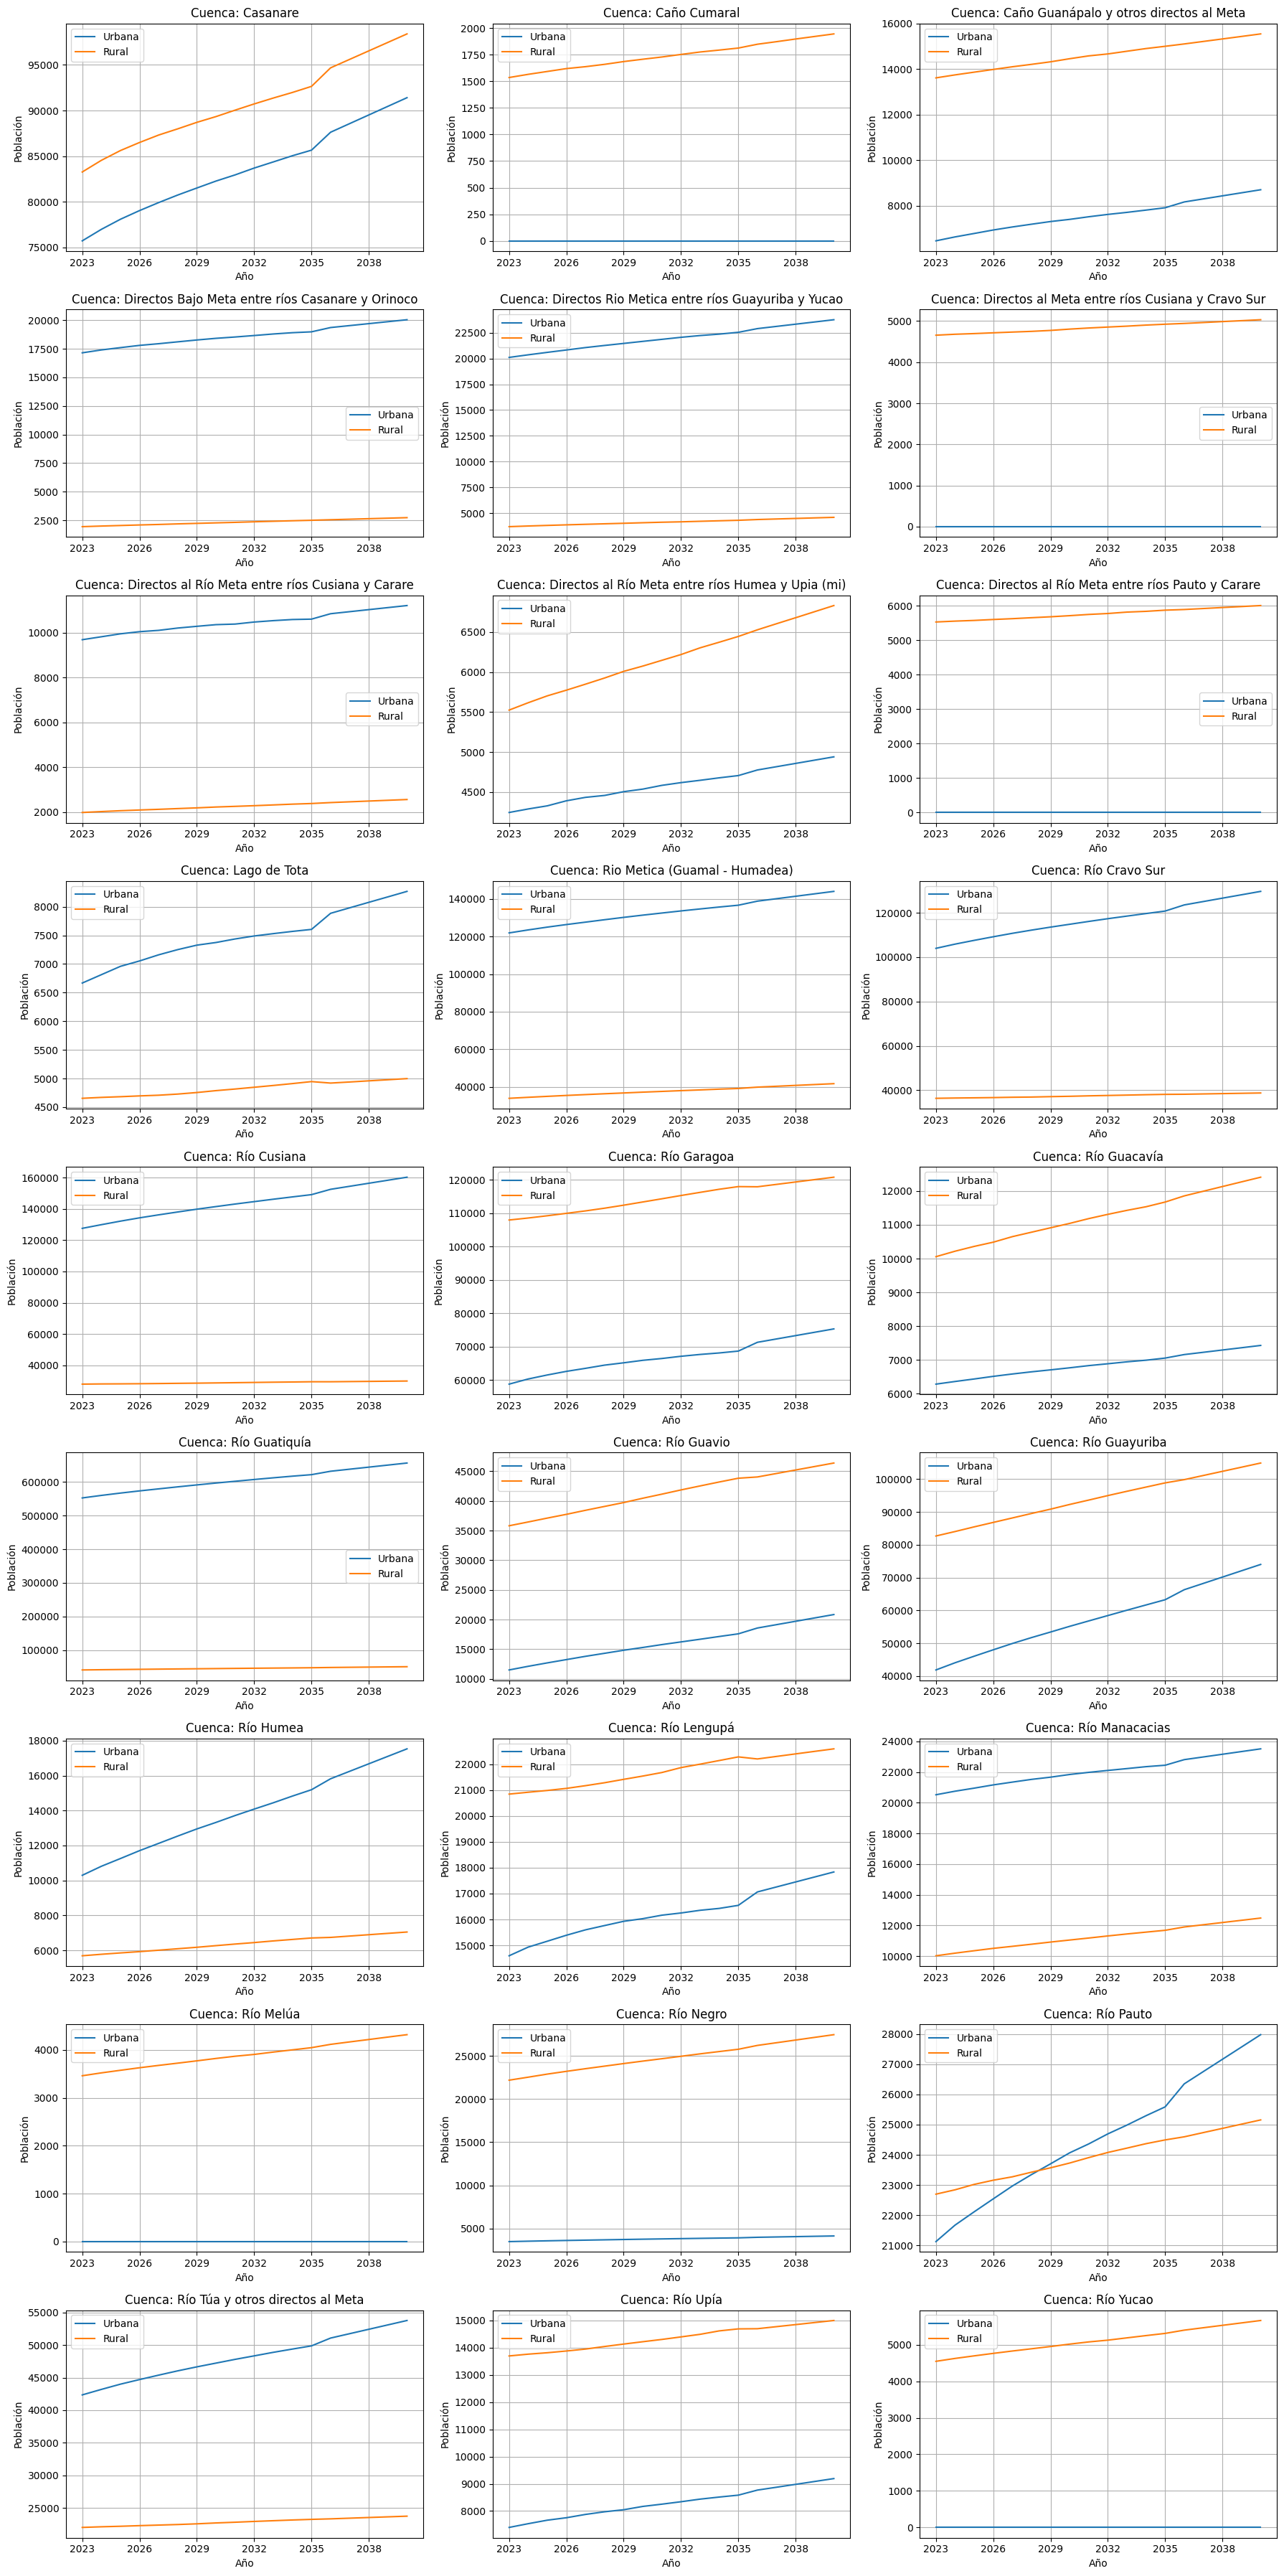

In [21]:
# Obtenemos las cuencas únicas
cuencas_unicas = poblacion_cuenca_filtrado['Cuenca'].unique()
# Configuramos el subplot con las nuevas especificaciones para el eje X
fig, axs = plt.subplots(9, 3, figsize=(18, 36))
fig.subplots_adjust(hspace=0.5, wspace=0.3)

# Aplanamos el array de axes para iterar más fácilmente
axs = axs.flatten()

# Generamos cada gráfica por cuenca
for i, cuenca in enumerate(cuencas_unicas):
    ax = axs[i]
    for area in ['Urbana', 'Rural']:
        datos_area = poblacion_cuenca_filtrado[(poblacion_cuenca_filtrado['Cuenca'] == cuenca) &
                                               (poblacion_cuenca_filtrado['Area'] == area)]
        ax.plot(datos_area['Año'], datos_area['Población'], label=f"{area}")

    ax.set_title(f"Cuenca: {cuenca}")
    ax.set_xlabel('Año')
    ax.set_ylabel('Población')
    ax.legend()
    ax.grid(True)


    # Ajustamos las etiquetas del eje X para que aparezcan como números enteros y cada 3 años
    ax.set_xticks(np.arange(2023, 2041, 3))
    ax.set_xticklabels(np.arange(2023, 2041, 3).astype(int))

# Eliminamos los axes vacíos en caso de que haya menos de 27 cuencas
for i in range(len(cuencas_unicas), 27):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()